In [1]:
#installing required libraries
!pip install category_encoders

In [2]:
#Importing required libraries and functions

#Libraries to load the dataset
import pandas as pd
import numpy as np

#Libraries/Functions for Data Pre-processing
import category_encoders as ce
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

#Functions for building ML/DL models
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor as knn
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from keras.layers import Dense, Dropout, LeakyReLU, ReLU
from keras.models import Sequential

#Functions for Data-visualisatoin
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/Datasets/COVID_19

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Datasets/COVID_19


**Part - 1**

In [0]:
#Loading the dataset
train = pd.read_excel('Train_dataset.xlsx')
test = pd.read_excel('Test_dataset.xlsx')

In [5]:
train.head()

,people_ID,Region,Gender,Designation,Name,Married,Children,Occupation,Mode_transport,cases/1M,Deaths/1M,comorbidity,Age,Coma score,Pulmonary score,cardiological pressure,Diuresis,Platelets,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month,Infect_Prob
0,1,Bhubaneshwar,Female,Mrs,mansi,YES,1.0,Farmer,Public,2,0,Hypertension,68,8,<400,Normal,441.0,154.0,93.0,233.0,82.0,58.0,27,7,3600000.0,1300000,2.0,49.135010
1,2,Bhubaneshwar,Female,Mrs,riya masi,YES,2.0,Farmer,Walk,2,0,Diabetes,64,15,<100,Stage-02,NaN,121.0,56.0,328.0,89.0,68.0,5,6,1600000.0,400000,1.0,51.147880
2,3,Bhubaneshwar,Female,Mrs,sunita,NO,1.0,Cleaner,Public,2,0,None,19,13,<300,Elevated,416.0,124.0,137.0,213.0,77.0,43.0,40,6,3400000.0,900000,1.0,73.224000
3,4,Bhubaneshwar,Female,Mrs,anjali @ babli,YES,1.0,Driver,Car,2,0,Coronary Heart Disease,33,9,<200,Stage-01,410.0,98.0,167.0,275.0,64.0,60.0,27,7,700000.0,2300000,1.0,48.779225
4,5,Bhubaneshwar,Female,Mrs,champa karketta,NO,2.0,Manufacturing,Car,2,0,Diabetes,23,7,<400,Normal,390.0,21.0,153.0,331.0,71.0,64.0,32,7,3200000.0,1100000,1.0,87.868800


In [6]:
train.describe()

,people_ID,Children,cases/1M,Deaths/1M,Age,Coma score,Diuresis,Platelets,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month,Infect_Prob
count,10714.000000,10403.000000,10714.000000,10714.000000,10714.000000,10714.000000,9998.000000,9790.000000,10698.000000,9600.000000,9600.000000,10679.000000,10714.000000,10714.000000,9.624000e+03,1.071400e+04,9991.000000,10714.000000
mean,10084.893784,1.062770,3.285888,0.523241,42.083722,9.013067,278.806261,87.795812,116.170967,275.292292,74.847396,52.632737,20.028094,5.015027,2.644919e+06,1.304713e+06,1.004604,52.280680
std,7108.663645,0.818222,2.721274,0.854303,15.323397,3.714970,97.985526,41.851103,55.178811,43.669692,14.869104,10.434293,11.828445,1.399770,1.383346e+06,6.075947e+05,0.815257,10.674667
min,1.000000,0.000000,1.000000,0.000000,16.000000,3.000000,110.000000,15.000000,20.000000,200.000000,50.000000,35.000000,0.000000,3.000000,3.000000e+05,3.000000e+05,0.000000,29.289600
25%,2679.250000,0.000000,2.000000,0.000000,29.000000,6.000000,194.000000,52.000000,68.000000,237.000000,62.000000,44.000000,10.000000,4.000000,1.400000e+06,8.000000e+05,0.000000,47.277426
50%,10003.500000,1.000000,2.000000,0.000000,42.000000,9.000000,276.000000,88.000000,117.000000,276.000000,75.000000,53.000000,20.000000,5.000000,2.600000e+06,1.300000e+06,1.000000,49.008389
75%,15141.750000,2.000000,4.000000,1.000000,55.000000,12.000000,364.000000,124.000000,165.000000,313.000000,88.000000,62.000000,30.000000,6.000000,3.800000e+06,1.800000e+06,2.000000,52.762313
max,22695.000000,2.000000,8.000000,2.000000,68.000000,15.000000,450.000000,160.000000,210.000000,350.000000,100.000000,70.000000,40.000000,7.000000,5.000000e+06,2.300000e+06,2.000000,97.632000


In [7]:
test.describe()

,people_ID,Children,cases/1M,Deaths/1M,Age,Coma score,Diuresis,Platelets,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month
count,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,1.449800e+04,1.449800e+04,14498.000000
mean,14469.963167,0.978963,5.886743,1.342737,42.083667,8.985860,280.657608,86.886467,114.082977,274.667264,75.021727,52.417920,19.997448,4.995724,2.654849e+06,1.300021e+06,1.002966
std,6826.922260,0.811833,4.651725,0.953566,15.326426,3.754762,98.240677,42.194450,55.207974,43.706160,14.549680,10.341219,11.887840,1.416303,1.375384e+06,6.055975e+05,0.818952
min,3887.000000,0.000000,0.000000,0.000000,16.000000,3.000000,110.000000,15.000000,20.000000,200.000000,50.000000,35.000000,0.000000,3.000000,3.000000e+05,3.000000e+05,0.000000
25%,7747.250000,0.000000,3.000000,1.000000,29.000000,6.000000,195.000000,51.000000,66.000000,237.000000,63.000000,43.000000,10.000000,4.000000,1.500000e+06,8.000000e+05,0.000000
50%,16467.500000,1.000000,4.000000,1.000000,42.000000,9.000000,280.000000,87.000000,113.000000,274.000000,75.000000,52.000000,20.000000,5.000000,2.700000e+06,1.300000e+06,1.000000
75%,20315.750000,2.000000,11.000000,2.000000,55.000000,12.000000,366.000000,124.000000,162.000000,312.000000,88.000000,61.000000,30.000000,6.000000,3.800000e+06,1.800000e+06,2.000000
max,25212.000000,2.000000,13.000000,3.000000,68.000000,15.000000,450.000000,160.000000,210.000000,350.000000,100.000000,70.000000,40.000000,7.000000,5.000000e+06,2.300000e+06,2.000000


In [8]:
train.columns

Index(['people_ID', 'Region', 'Gender', 'Designation', 'Name', 'Married',
       'Children', 'Occupation', 'Mode_transport', 'cases/1M', 'Deaths/1M',
       'comorbidity', 'Age', 'Coma score', 'Pulmonary score',
       'cardiological pressure', 'Diuresis', 'Platelets', 'HBB', 'd-dimer',
       'Heart rate', 'HDL cholesterol', 'Charlson Index', 'Blood Glucose',
       'Insurance', 'salary', 'FT/month', 'Infect_Prob'],
      dtype='object')

In [0]:
#Dropping the columns which are not essential
to_drop_1 = ['people_ID','Designation', 'Name','Infect_Prob','Deaths/1M']
new_df = train.drop(to_drop_1 ,axis=1)
Y = train['Infect_Prob']

to_drop_2 = ['people_ID','Designation','Name','Deaths/1M']
test_id = test['people_ID']
test_df = test.drop(to_drop_2, axis=1)

In [10]:
new_df['Region'].value_counts()

Chennai         2581
Bengaluru       2573
Chandigarh      2563
Bhubaneshwar    2537
Delhi            460
Name: Region, dtype: int64

In [11]:
test_df['Region'].value_counts()

Pune                  2503
Thiruvananthapuram    2502
Kolkata               2483
Mumbai                2475
Hyderabad             2457
Delhi                 2078
Name: Region, dtype: int64

In [0]:
#Dropping the column - 'Region' as both test and train dataset contain different sets of values
new_df = new_df.drop(['Region'],axis=1)
test_df = test_df.drop(['Region'],axis=1)

In [0]:
#Making list of both categorical features and numerical features
cat_col = ['Gender','Married','Occupation','Mode_transport','comorbidity','Pulmonary score','cardiological pressure']
con_col = ['cases/1M','Age','Coma score','Diuresis','Platelets', 'HBB', 'd-dimer', 'Heart rate', 'HDL cholesterol','Charlson Index', 'Blood Glucose', 'Insurance', 'salary', 'FT/month']

In [14]:
#Counting non-NaN values in each columns
new_df.count()

Gender                    10714
Married                   10714
Children                  10403
Occupation                 9967
Mode_transport            10711
cases/1M                  10714
comorbidity               10488
Age                       10714
Coma score                10714
Pulmonary score           10714
cardiological pressure    10617
Diuresis                   9998
Platelets                  9790
HBB                       10698
d-dimer                    9600
Heart rate                 9600
HDL cholesterol           10679
Charlson Index            10714
Blood Glucose             10714
Insurance                  9624
salary                    10714
FT/month                   9991
dtype: int64

In [0]:
#Defining columns to be filled
to_be_filled = ['Children','Occupation','Mode_transport','comorbidity','cardiological pressure','Diuresis','Platelets','HBB','d-dimer','Heart rate','HDL cholesterol','Insurance','FT/month']

#Function to fill the NaN values
#NaN is replaced with most occuring value if the feature is categorical else filled with median value
def fill_values(df,col):
  if((col in cat_col) or (col=='Children')):
    df[col] = df[col].fillna(df[col].value_counts().index[0])
  else:
    df[col] = df[col].fillna(df[col].median())
  return df

for col in to_be_filled:
  new_df = fill_values(new_df,col)

In [0]:
#Numerical features are scaled, thus no single feature can pre-dominate the others
scaler = MinMaxScaler()
def scale_col(df,col):
  df[col] = pd.DataFrame(scaler.fit_transform(df[col].values.reshape(-1,1)))
  test_df[col] = pd.DataFrame(scaler.transform(test_df[col].values.reshape(-1,1)))
  return df

for col in con_col:
  new_df = scale_col(new_df,col)

In [0]:
#One-hot encoding categorical features as to use them effectively in the model
cat_col2 = cat_col.copy()
cat_col2.remove('Gender')
cat_col2.remove('Married')

le = LabelEncoder()
new_df['Gender'] = le.fit_transform(new_df['Gender'])
test_df['Gender'] = le.transform(test_df['Gender'])
new_df['Married'] = le.fit_transform(new_df['Married'])
test_df['Married'] = le.transform(test_df['Married'])

ce_bin = ce.OneHotEncoder(cols = cat_col2)
new_df = ce_bin.fit_transform(new_df)
test_df = ce_bin.transform(test_df)

In [18]:
new_df.head()

,Gender,Married,Children,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,Occupation_9,Mode_transport_1,Mode_transport_2,Mode_transport_3,cases/1M,comorbidity_1,comorbidity_2,comorbidity_3,comorbidity_4,Age,Coma score,Pulmonary score_1,Pulmonary score_2,Pulmonary score_3,Pulmonary score_4,cardiological pressure_1,cardiological pressure_2,cardiological pressure_3,cardiological pressure_4,Diuresis,Platelets,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month
0,0,1,1.0,1,0,0,0,0,0,0,0,0,1,0,0,0.142857,1,0,0,0,1.000000,0.416667,1,0,0,0,1,0,0,0,0.973529,0.958621,0.384211,0.220000,0.64,0.657143,0.675,1.00,0.702128,0.50,1.0
1,0,1,2.0,1,0,0,0,0,0,0,0,0,0,1,0,0.142857,0,1,0,0,0.923077,1.000000,0,1,0,0,0,1,0,0,0.488235,0.731034,0.189474,0.853333,0.78,0.942857,0.125,0.75,0.276596,0.05,0.5
2,0,0,1.0,0,1,0,0,0,0,0,0,0,1,0,0,0.142857,0,0,1,0,0.057692,0.833333,0,0,1,0,0,0,1,0,0.900000,0.751724,0.615789,0.086667,0.54,0.228571,1.000,0.75,0.659574,0.30,0.5
3,0,1,1.0,0,0,1,0,0,0,0,0,0,0,0,1,0.142857,0,0,0,1,0.326923,0.500000,0,0,0,1,0,0,0,1,0.882353,0.572414,0.773684,0.500000,0.28,0.714286,0.675,1.00,0.085106,1.00,0.5
4,0,0,2.0,0,0,0,1,0,0,0,0,0,0,0,1,0.142857,0,1,0,0,0.134615,0.333333,1,0,0,0,1,0,0,0,0.823529,0.041379,0.700000,0.873333,0.42,0.828571,0.800,1.00,0.617021,0.40,0.5


In [0]:
#Splitting train and validation set in the ratio of 0.15 (as training dataset is less)
X_train, X_test, y_train, y_test = train_test_split(new_df, Y, test_size=0.15, random_state=0)

In [20]:
print(X_train.shape)
print(X_test.shape)

(9106, 41)
(1608, 41)


In [21]:
#Using Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
y_pred = model_lr.predict(X_test)
mse(y_test,y_pred)

80.41890628990959

In [22]:
#Using Polynomial Regression (degree - 2)
poly = PolynomialFeatures(2)
tmp_train = poly.fit_transform(X_train)
tmp_test = poly.fit_transform(X_test)

model_poly = LinearRegression()
model_poly.fit(tmp_train,y_train)
y_pred = model_poly.predict(tmp_test)
mse(y_test,y_pred)

1.935192677039263e+22

In [23]:
#Using KNearestNeighbors Regression
model_knn = knn(n_neighbors=36)
model_knn.fit(X_train,y_train)
y_pred = model_knn.predict(X_test)
mse(y_test,y_pred)

86.90249251575248

In [24]:
#Using Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=250, max_depth=8, random_state=0)
model_rf.fit(X_train,y_train)
y_pred = model_rf.predict(X_test)
mse(y_test, y_pred)

75.4450516061491

In [25]:
#Using XGBoost Regressor
model_x = XGBRegressor(n_estimators=250, max_depth=10, random_state=0)
model_x.fit(X_train,y_train)
y_pred = model_x.predict(X_test)
mse(y_test, y_pred)

[20:28:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


90.37891247393505

In [26]:
#Using Neural Network
model_nn = Sequential([
                       
                       Dense(15,activation='relu',input_shape=(X_train.shape[1],)),
                       Dense(10,activation='relu'),
                       Dense(1)

])
model_nn.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                630       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


In [27]:
model_nn.compile(optimizer='adam', loss='mean_squared_error')
model_nn.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
y_pred = model_nn.predict(X_test)
mse(y_test,y_pred)





Train on 9106 samples, validate on 1608 samples
Epoch 1/50





9106/9106 [==============================] - 1s 72us/step - loss: 2263.1018 - val_loss: 779.4412
Epoch 2/50
9106/9106 [==============================] - 0s 43us/step - loss: 225.9979 - val_loss: 137.7783
Epoch 3/50
9106/9106 [==============================] - 0s 42us/step - loss: 136.6673 - val_loss: 130.6098
Epoch 4/50
9106/9106 [==============================] - 0s 41us/step - loss: 129.6632 - val_loss: 123.7360
Epoch 5/50
9106/9106 [==============================] - 0s 41us/step - loss: 122.7959 - val_loss: 117.0939
Epoch 6/50
9106/9106 [==============================] - 0s 42us/step - loss: 116.5047 - val_loss: 111.1223
Epoch 7/50
9106/9106 [==============================] - 0s 41us/step - loss: 110.6554 - val_loss: 105.9485
Epoch 8/50
9106/9106 [==============================] - 0s 43us/step - loss: 105.7115 - val_loss: 101.3223
Epoch 9/50
9106/9106 [==============================] - 0s 44us/step - loss: 101.4574 

79.62354618497632

**Part - 2**

In [28]:
#Loading Time-Series data of Diuresis rate
xls = pd.ExcelFile('Train_dataset.xlsx')
diu_df = pd.read_excel(xls, 'Diuresis_TS')
diu_df.head()

,people_ID,2020-03-20 00:00:00,2020-03-21 00:00:00,2020-03-22 00:00:00,2020-03-23 00:00:00,2020-03-24 00:00:00,2020-03-25 00:00:00,2020-03-26 00:00:00
0,1,441,544.2,669.64,821.368,1002.2416,1215.68992,1472.627904
1,2,151,197.2,253.24,321.688,399.9256,492.91072,606.892864
2,3,416,515.2,632.44,776.728,947.7736,1150.32832,1395.793984
3,4,410,506.0,621.40,761.880,928.1560,1126.78720,1368.344640
4,5,390,483.0,595.00,730.200,892.8400,1084.40800,1315.889600


In [29]:
#Checking for NaN values
diu_df.count()

people_ID              10714
2020-03-20 00:00:00    10714
2020-03-21 00:00:00    10714
2020-03-22 00:00:00    10714
2020-03-23 00:00:00    10714
2020-03-24 00:00:00    10714
2020-03-25 00:00:00    10714
2020-03-26 00:00:00    10714
dtype: int64

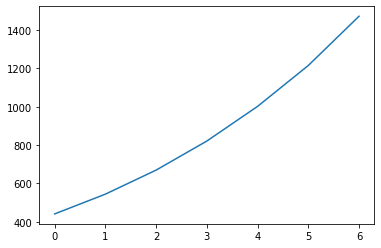

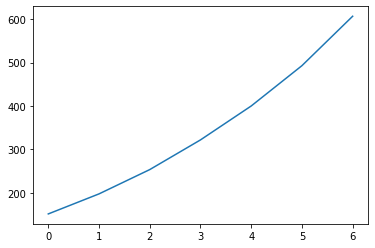

In [30]:
#Plotting Diuresis rate Vs Time(in Days)
for i in range(2):
  tmp = diu_df.iloc[i]
  tmp = tmp.to_numpy()
  tmp = np.delete(tmp,0,axis=0)
  plt.plot([0,1,2,3,4,5,6],tmp)
  plt.show()

[445.2635276190479, 540.2192640000001, 665.3422079999998, 820.6323596190473, 1006.0897188571423, 1221.714285714285, 1467.5060601904754, 1743.4650422857133]


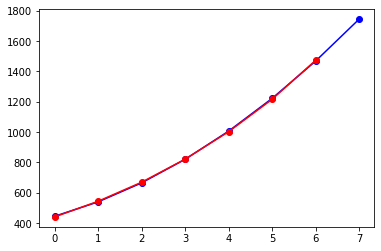

In [31]:
#Using Polynomial Regression to find the Diuresis rate on 27th March
tmp = diu_df.iloc[0]
tmp = tmp.to_numpy()
tmp = np.delete(tmp,0,axis=0)
tmp2 = np.asarray([0,1,2,3,4,5,6])
tmp = tmp.reshape(-1,1)
tmp2 = tmp2.reshape(-1,1)

poly = PolynomialFeatures(2)
tmp2 = poly.fit_transform(tmp2)

model_poly = LinearRegression()
model_poly.fit(tmp2,tmp)

y = []
for i in range(8):
  t = np.asarray( [1,i,i**2] )
  t = t.reshape(1,3)
  y_p = model_poly.predict(t)
  y.append(y_p[0][0])
print(y)
plt.plot(range(8),y,'o-b')

tmp = diu_df.iloc[0]
tmp = tmp.to_numpy()
tmp = np.delete(tmp,0,axis=0)
plt.plot([0,1,2,3,4,5,6],tmp,'o-r')
plt.show()

In [0]:
#Predicting the value of Diuresis rate on 27th for each person on train dataset
y_diu = []
for i in range(diu_df.shape[0]):
  tmp = diu_df.iloc[i]
  tmp = tmp.to_numpy()
  tmp = np.delete(tmp,0,axis=0)
  tmp2 = np.asarray([0,1,2,3,4,5,6])
  tmp = tmp.reshape(-1,1)

  poly = PolynomialFeatures(2)
  tmp2 = tmp2.reshape(-1,1)
  tmp2 = poly.fit_transform(tmp2)

  model_poly = LinearRegression()
  model_poly.fit(tmp2,tmp)
  t = np.asarray( [1,7,49] )
  t = t.reshape(1,3)
  y_p = model_poly.predict(t)
  y_diu.append(y_p[0][0])
y_df = pd.DataFrame()
y_df['diu'] = y_diu

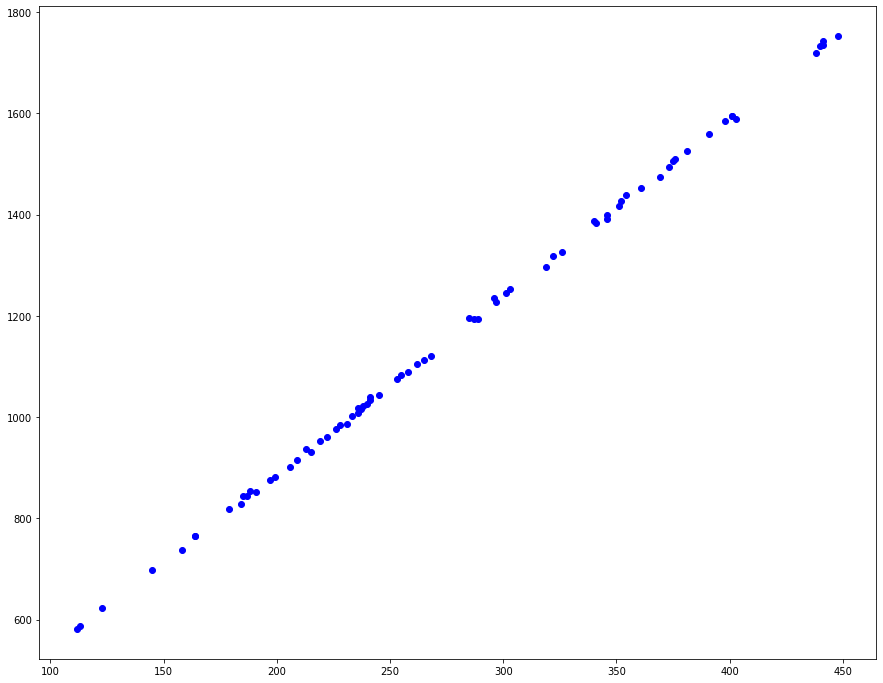

In [33]:
#Plotting Diuresis rate on March 20 Vs Diuresis rate on March 27
f = figure(figsize=(15,12))
plt.plot(diu_df[diu_df.columns[1]][::150],y_df[::150],'ob')
plt.show()

In [0]:
tr_diu = pd.DataFrame(scaler.fit_transform(diu_df[diu_df.columns[1]].values.reshape(-1,1)))

In [0]:
#Using Linear Regression to find the Diuresis rate on March 27th for the people in test dataset
mod = LinearRegression()
mod.fit(tr_diu,y_df)
diu_pred = mod.predict(test_df['Diuresis'].values.reshape(-1,1))

test_df_2 = test_df.copy()
scaler.fit(diu_df[diu_df.columns[1]].values.reshape(-1,1))
test_df_2['Diuresis'] = pd.DataFrame(scaler.transform(diu_pred))

In [0]:
#Predicting the probility of infection using Random Forest Regression on 20th March
y_pred = model_rf.predict(test_df)
output_1 = pd.DataFrame({'people_ID':test_id,'Infect_Prob':y_pred})
output_1.to_csv('Prob_20_03.csv',index=False)

In [0]:
#Predicting the probility of infection using Random Forest Regression on 27th March
y_pred_2 = model_rf.predict(test_df_2)
output_2 = pd.DataFrame({'people_ID':test_id,'Infect_Prob':y_pred_2})
output_2.to_csv('Prob_27_03.csv',index=False)